# Networks analysis

**(Imports)**

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

## Network analyzer code

The following is a function which will extract all the interesting features from the network data.

In [3]:
def analyze_network(G):
    # Check if it is a multi-graph, if so, convert it to a simple graph
    if isinstance(G, (nx.MultiGraph, nx.MultiDiGraph)):
        if isinstance(G, nx.MultiGraph):
            # Convert multiple undirected graphs to simple undirected graphs
            new_G = nx.Graph()
            for u, v in G.edges():
                if not new_G.has_edge(u, v):
                    new_G.add_edge(u, v)
            G = new_G
        else:
            # Convert Multiple Directional Graphs to Simple Directional Graphs
            new_G = nx.DiGraph()
            for u, v in G.edges():
                if not new_G.has_edge(u, v):
                    new_G.add_edge(u, v)
            G = new_G

    # Basic Network Indicators
    basic_stats = {
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'degrees': [d for n, d in G.degree()],
        'min_degree': min(d for n, d in G.degree()),
        'max_degree': max(d for n, d in G.degree()),
        'avg_degree': np.mean([d for n, d in G.degree()]),
        # Average clustering coefficient
        'avg_clustering': nx.average_clustering(G),
        # Degree Correlation
        'assortativity': nx.degree_assortativity_coefficient(G)
    }

    # Connectivity Processing
    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G_lcc = G.subgraph(largest_cc)
        basic_stats['avg_path_length'] = nx.average_shortest_path_length(G_lcc)
        basic_stats['diameter'] = nx.diameter(G_lcc)
    else:
        basic_stats['avg_path_length'] = nx.average_shortest_path_length(G)
        basic_stats['diameter'] = nx.diameter(G)

    # Degree Distribution Analysis 
    degrees = np.array(basic_stats['degrees'])
    k_min = np.min(degrees)
    k_max = np.max(degrees)

    if k_min == 0:
        k_min = 1  # avoid log(0)

    log_k_min = np.log10(k_min)
    log_k_max = np.log10(k_max + 1)
    num_bins = 10
    log_bins = np.linspace(log_k_min, log_k_max, num_bins + 1)
    bins = 10 ** log_bins

    counts, _ = np.histogram(degrees, bins=bins)
    probabilities = counts / len(degrees)
    ccdf = np.cumsum(probabilities[::-1])[::-1]

    bin_centers = 10 ** ((log_bins[:-1] + log_bins[1:]) / 2)

    # Central Analysis
    centralities = {
        'degree': nx.degree_centrality(G),
        'betweenness': nx.betweenness_centrality(G),
    }

    # Dealing with possible convergence of eigenvector centrality
    try:
        centralities['eigenvector'] = nx.eigenvector_centrality(G)
    except nx.PowerIterationFailedConvergence:
        try:
            centralities['eigenvector'] = nx.eigenvector_centrality_numpy(G)
        except Exception as err:
            print(f"Unexpected {err=}, {type(err)=}")
            centralities['eigenvector'] = {}

    # Extract the top five
    top_central = {}
    for metric in centralities:
        sorted_nodes = sorted(centralities[metric].items(), key=lambda x: x[1], reverse=True)[:5]
        top_central[metric] = [(n, round(v, 4)) for n, v in sorted_nodes]

    return {
        'basic_stats': basic_stats,
        'degree_distribution': (bin_centers, ccdf),
        'top_central': top_central
    }


## Network parameters printer

This function will pretty-print to us the interesting properties of the network in question. Accepts results from the `analyze_network`

In [4]:
def print_stats(results):
    # Printing Basic Statistics
    print("Network Statistics:")
    print(f"Nodes: {results['basic_stats']['nodes']}")
    print(f"Edges: {results['basic_stats']['edges']}")
    print(f"Min Degree: {results['basic_stats']['min_degree']}")
    print(f"Max Degree: {results['basic_stats']['max_degree']}")
    print(f"Avg Degree: {results['basic_stats']['avg_degree']:.2f}")
    print(f"Avg Clustering: {results['basic_stats']['avg_clustering']:.4f}")
    print(f"Assortativity: {results['basic_stats']['assortativity']:.4f}")
    print(f"Avg Path Length: {results['basic_stats']['avg_path_length']:.2f}")
    print(f"Diameter: {results['basic_stats']['diameter']}")

    # Distribution of degree
    plt.figure(figsize=(10, 6))
    plt.loglog(results['degree_distribution'][0], results['degree_distribution'][1], 'bo-')
    plt.title('Degree Distribution (CCDF in log-log scale)')
    plt.xlabel('log(k)')
    plt.ylabel('log(CCDF(k))')
    plt.grid(True)
    plt.show()

    # Display Central Results
    print("\nTop Central Nodes:")
    for metric, nodes in results['top_central'].items():
        print(f"\n{metric.capitalize()}:")
        for node, score in nodes:
            print(f"Node {node}: {score}")

## Network 1

In [5]:
G = nx.read_pajek('./net1.net')
results = analyze_network(G)

Network Statistics:
Nodes: 5000
Edges: 25000
Min Degree: 6
Max Degree: 16
Avg Degree: 10.00
Avg Clustering: 0.4141
Assortativity: -0.0097
Avg Path Length: 5.12
Diameter: 8


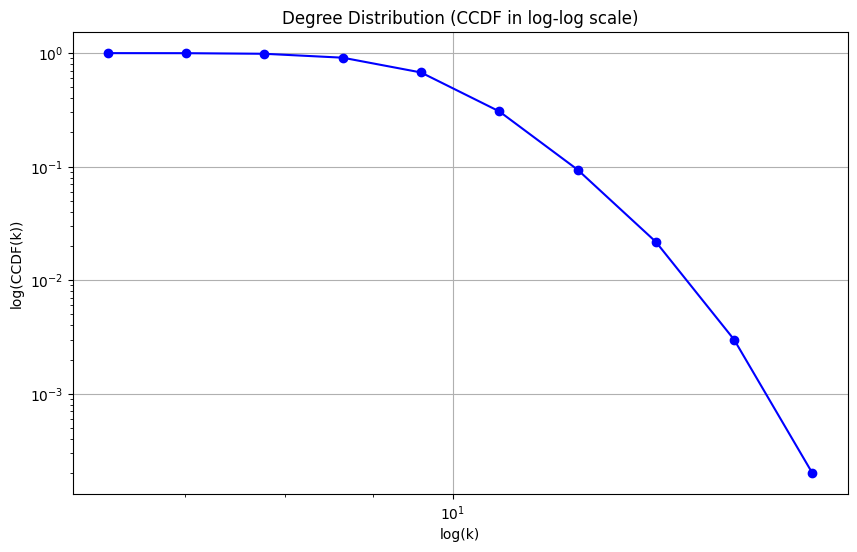


Top Central Nodes:

Degree:
Node 1693: 0.0032
Node 1579: 0.003
Node 651: 0.003
Node 4891: 0.003
Node 41: 0.0028

Betweenness:
Node 4747: 0.0041
Node 2645: 0.004
Node 230: 0.0038
Node 4360: 0.0038
Node 1579: 0.0037

Eigenvector:
Node 651: 0.0286
Node 1937: 0.0265
Node 4526: 0.0256
Node 4398: 0.0253
Node 1939: 0.0252


In [6]:
print_stats(results)

## Network 2

In [7]:
G = nx.read_pajek('./net2.net')
results = analyze_network(G)

Network Statistics:
Nodes: 5000
Edges: 24873
Min Degree: 1
Max Degree: 24
Avg Degree: 9.95
Avg Clustering: 0.0021
Assortativity: -0.0057
Avg Path Length: 3.96
Diameter: 7


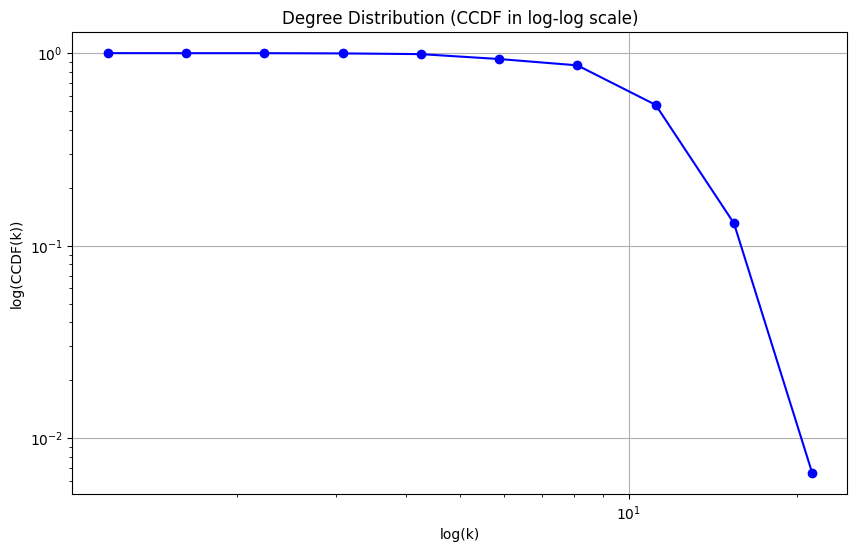


Top Central Nodes:

Degree:
Node 1581: 0.0048
Node 787: 0.0046
Node 52: 0.0042
Node 1990: 0.0042
Node 4917: 0.0042

Betweenness:
Node 1581: 0.0033
Node 787: 0.0026
Node 4382: 0.0025
Node 52: 0.0023
Node 2375: 0.0023

Eigenvector:
Node 1581: 0.0412
Node 3233: 0.0343
Node 787: 0.0341
Node 2375: 0.0337
Node 131: 0.0335


In [8]:
print_stats(results)

## Network 3

In [9]:
G = nx.read_pajek('./net3.net')
results = analyze_network(G)

Network Statistics:
Nodes: 5000
Edges: 23508
Min Degree: 3
Max Degree: 732
Avg Degree: 9.40
Avg Clustering: 0.0862
Assortativity: -0.1339
Avg Path Length: 3.01
Diameter: 5


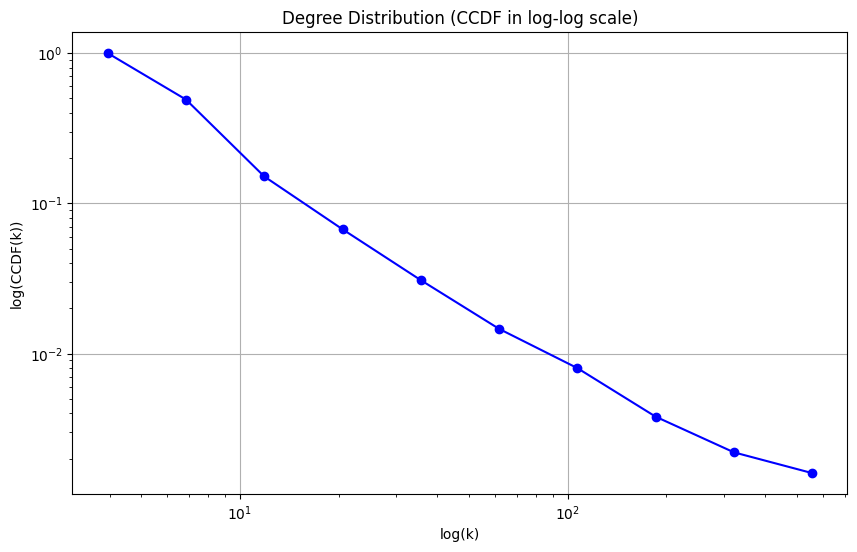


Top Central Nodes:

Degree:
Node 5: 0.1464
Node 7: 0.1382
Node 2: 0.1252
Node 0: 0.124
Node 6: 0.111

Betweenness:
Node 5: 0.1378
Node 7: 0.1277
Node 0: 0.1113
Node 2: 0.1093
Node 6: 0.0943

Eigenvector:
Node 5: 0.2592
Node 7: 0.2417
Node 2: 0.2254
Node 0: 0.2254
Node 3: 0.207


In [10]:
print_stats(results)

## Network 4

In [11]:
G = nx.read_pajek('./net4.net')
results = analyze_network(G)

Network Statistics:
Nodes: 5000
Edges: 24975
Min Degree: 5
Max Degree: 210
Avg Degree: 9.99
Avg Clustering: 0.0107
Assortativity: -0.0325
Avg Path Length: 3.49
Diameter: 5


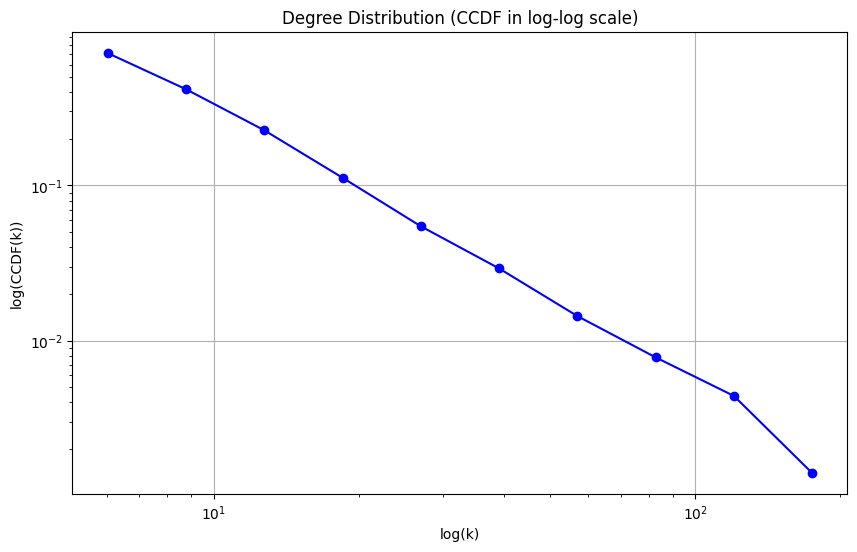


Top Central Nodes:

Degree:
Node 6: 0.042
Node 0: 0.0412
Node 9: 0.0408
Node 10: 0.0326
Node 8: 0.0324

Betweenness:
Node 0: 0.0605
Node 6: 0.0576
Node 9: 0.0553
Node 8: 0.0391
Node 3: 0.0379

Eigenvector:
Node 6: 0.2239
Node 0: 0.2234
Node 9: 0.2062
Node 8: 0.1741
Node 3: 0.1686


In [12]:
print_stats(results)

## Network 5

In [13]:
G = nx.read_pajek('./net5.net')
results = analyze_network(G)

Unexpected err=AmbiguousSolution('`eigenvector_centrality_numpy` does not give consistent results for disconnected graphs'), type(err)=<class 'networkx.exception.AmbiguousSolution'>


Numpy is complaining that the network is disconnected

Network Statistics:
Nodes: 200
Edges: 465
Min Degree: 1
Max Degree: 10
Avg Degree: 4.65
Avg Clustering: 0.6107
Assortativity: 0.5502
Avg Path Length: 13.13
Diameter: 35


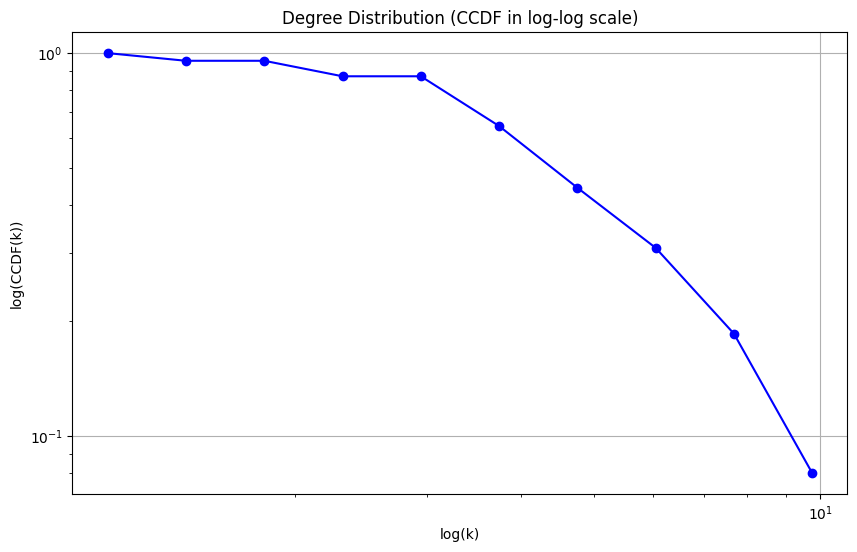


Top Central Nodes:

Degree:
Node 18: 0.0503
Node 33: 0.0503
Node 37: 0.0503
Node 170: 0.0503
Node 126: 0.0503

Betweenness:
Node 177: 0.1955
Node 129: 0.1933
Node 78: 0.1926
Node 84: 0.1926
Node 104: 0.1923

Eigenvector:


In [14]:
print_stats(results)

In [15]:
positions = {}
with open('positions_net5.txt', 'r') as f:
    next(f)  # Skip the header line
    for line in f:
        node, x, y = line.strip().split()
        positions[node] = (float(x), float(y))


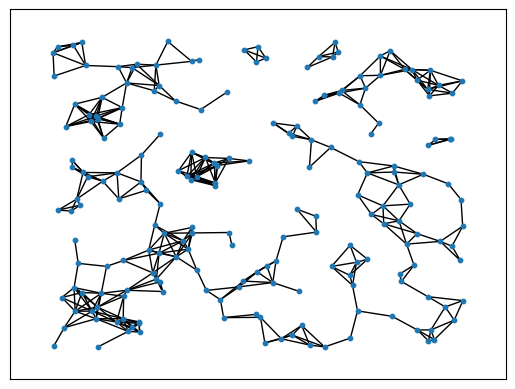

In [16]:
nx.draw_networkx(G, pos=positions, with_labels=False, node_size=10)

Judging by the visualization, maybe it's some sort of random walker algorigthm?.. Something like, generate 200 nodes then put ~10 walkers in it and they will connect nodes by choosing the random neighbor on every step?